<a href="https://colab.research.google.com/github/amilkh/cs230-fer/blob/class-weight/fer2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/cs230 project/collab/fer2013/fer2013.csv')

#print('Number of samples in the dataset: ', data.shape[0])
# Transform images from strings to lists of integers. TODO: use an array cast
data['pixels'] = data['pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
data_train = data[data['Usage']=='Training']
data_dev = data[data['Usage']=='PublicTest']

print('Number samples in the training dataset: ', data_train.shape[0])
print('Number samples in the development dataset: ', data_dev.shape[0])

# Retrieve train input and target
X_train, y_train = data_train['pixels'].tolist(), data_train['emotion'].values
# Reshape images to 4D (num_samples, width, height, num_channels)
X_train = np.array(X_train, dtype='float32').reshape(-1,48,48,1)
# Normalize images with max (the maximum pixel intensity is 255)
X_train = X_train/255.0

# Retrieve dev input and target
X_dev, y_dev = data_dev['pixels'].tolist(), data_dev['emotion'].values
X_dev = np.array(X_dev, dtype='float32').reshape(-1,48,48,1)
X_dev = X_dev/255.0

Number samples in the training dataset:  28709
Number samples in the development dataset:  3589


In [33]:
emotion_cat = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

# See the training distribution
train_counts = data_train['emotion'].value_counts().reset_index(drop=False)
train_counts.columns = ['emotion', 'number_samples']
train_counts['emotion'] = train_counts['emotion'].map(emotion_cat)
train_counts

,emotion,number_samples
0,Happy,7215
1,Neutral,4965
2,Sad,4830
3,Fear,4097
4,Angry,3995
5,Surprise,3171
6,Disgust,436


In [0]:
# Baseline model
model = tf.keras.models.Sequential([
    InputLayer(input_shape=(48,48,1),name="input"),
    Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',name="conv1"),
    Dropout(0.25),
    Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',name="conv2"),
    Dropout(0.25),
    MaxPool2D(pool_size=(2,2),name="maxpool1"),
    Conv2D(filters=64,kernel_size=3,activation='relu',padding='same',name="conv3"),
    Dropout(0.25),
    Conv2D(filters=64,kernel_size=3,activation='relu',padding='same',name="conv4"),
    Dropout(0.25),
    Flatten(),
    Dense(1024,input_shape=(24*24*64,1),activation='relu',name='fc1'),
    Dense(7,input_shape=(1024,1),activation='softmax',name='fc-softmax')
])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [9]:
model.fit(X_train,y_train,batch_size=32,epochs=5,validation_data=(X_dev, y_dev))

Train on 28709 samples, validate on 3589 samples
Epoch 1/5
28709/28709 [==============================] - 32s 1ms/sample - loss: 1.7170 - acc: 0.3148 - val_loss: 1.5427 - val_acc: 0.4076
Epoch 2/5
28709/28709 [==============================] - 25s 875us/sample - loss: 1.4510 - acc: 0.4364 - val_loss: 1.3782 - val_acc: 0.4556
Epoch 3/5
28709/28709 [==============================] - 25s 876us/sample - loss: 1.2596 - acc: 0.5180 - val_loss: 1.2793 - val_acc: 0.5130
Epoch 4/5
28709/28709 [==============================] - 25s 876us/sample - loss: 1.0411 - acc: 0.6110 - val_loss: 1.2638 - val_acc: 0.5249
Epoch 5/5
28709/28709 [==============================] - 25s 878us/sample - loss: 0.7474 - acc: 0.7292 - val_loss: 1.3293 - val_acc: 0.5286


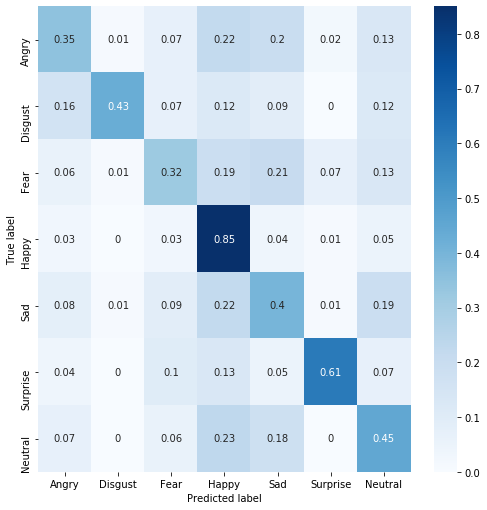

In [29]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

y_pred = np.argmax(model.predict(X_dev), axis=1)

cmat_df=pd.DataFrame(
  confusion_matrix(y_dev, y_pred,normalize='true').round(2),
  index=emotion_cat.values(), 
  columns=emotion_cat.values()
  )

plt.figure(figsize=(7,7))
heatmap(cmat_df,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()